## Compare filters

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from gcm_filters import filter
from gcm_filters.kernels import GridType
from gaussian_filter import gaussian_filter
import cmocean
import xarray as xr


ModuleNotFoundError: No module named 'cmocean'

Script parameters

In [49]:
filter_scale=4
cmap='Spectral'
vmax=0.2
vmin=-vmax

plt_args = dict(vmin=vmin, vmax=vmax, cmap=cmap)

Read the data from North Atlantic


In [50]:
from read_data import read_data

grid_data, data = read_data()
grid_data = grid_data.compute().reset_coords()

data = data['usurf'].isel(time=0).sel(xu_ocean=slice(-50, -30),
                                      yu_ocean=slice(20, 40)).compute()

Question: how do we address continents?

In [51]:
grid_data_save = grid_data
grid_data = grid_data[['dxt', 'dyt', 'dxu', 'dyu', 'area_u']]

Problem: we need the grid vars to be on the same grid as the field to
be filtered. Here I've interpolated, but I think this is not right,
we can probably just redefine the coords of dxt and dyt to be those of the
velocities, we'll just have to be careful.

In [52]:
grid_data['dxt'] = grid_data['dxt'].interp(dict(xt_ocean=data.xu_ocean,
                                  yt_ocean=data.yu_ocean))
grid_data['dyt'] = grid_data['dyt'].interp(dict(xt_ocean=data.xu_ocean,
                                  yt_ocean=data.yu_ocean))
grid_data = grid_data.sel(xu_ocean=slice(-50, -30), yu_ocean=slice(20, 40))
del grid_data['xt_ocean']
del grid_data['yt_ocean']
print(grid_data)

<xarray.Dataset>
Dimensions:   (xu_ocean: 200, yu_ocean: 233)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -49.9 -49.8 -49.7 -49.6 ... -30.2 -30.1 -30.0
  * yu_ocean  (yu_ocean) float64 20.08 20.17 20.26 20.36 ... 39.84 39.91 39.99
    time      object 0181-01-01 12:00:00
Data variables:
    dxt       (yu_ocean, xu_ocean) float64 1.044e+04 1.044e+04 ... 8.519e+03
    dyt       (yu_ocean, xu_ocean) float64 1.044e+04 1.044e+04 ... 8.519e+03
    dxu       (yu_ocean, xu_ocean) float64 1.044e+04 1.044e+04 ... 8.519e+03
    dyu       (yu_ocean, xu_ocean) float64 1.044e+04 1.044e+04 ... 8.519e+03
    area_u    (yu_ocean, xu_ocean) float32 1.091e+08 1.091e+08 ... 7.258e+07
Attributes:
    NCO:      4.0.3


Create the filter and print its specs

In [65]:
dx_min = np.min(grid_data['dxt'].values)
mom5_filter = filter.Filter(16*dx_min, dx_min=dx_min, n_steps=30,
                                 filter_shape=filter.FilterShape.GAUSSIAN,
                                 grid_vars=grid_data,
                                 grid_type=GridType.MOM5)
print(mom5_filter.filter_spec)


FilterSpec(n_lap_steps=30, s_l=array([1.09775920e-09, 3.28226289e-09, 6.85514257e-09, 1.17931200e-08,
       1.80484676e-08, 2.55561599e-08, 3.42370846e-08, 4.39994273e-08,
       5.47398062e-08, 6.63444257e-08, 7.86903057e-08, 9.16465966e-08,
       1.05075971e-07, 1.18836083e-07, 1.32781078e-07, 1.46763139e-07,
       1.60634057e-07, 1.74246799e-07, 1.87457068e-07, 2.00124833e-07,
       2.12115816e-07, 2.23302909e-07, 2.33567528e-07, 2.42800869e-07,
       2.50905060e-07, 2.57794205e-07, 2.63395299e-07, 2.67649049e-07,
       2.70510807e-07, 2.71981889e-07]), n_bih_steps=0, s_b=array([], dtype=complex128))


Carry out filtering operation

In [66]:
filtered_data = mom5_filter.apply(data, dims=['yu_ocean', 'xu_ocean'])

Plot the result

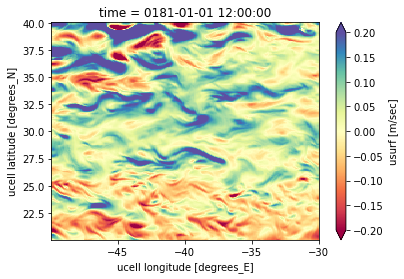

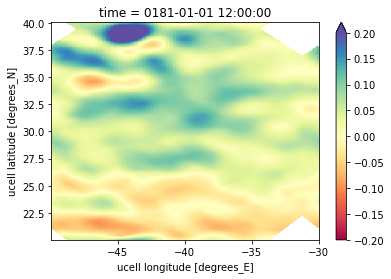

In [67]:
plt.figure()
data.plot(**plt_args)
plt.figure()
filtered_data.plot(**plt_args)
plt.show()


Now with a standard Gaussian filter

In [42]:
grid_data = grid_data_save
data2 = data.fillna(0.)
filtered_data2 = gaussian_filter(data2, grid_data, scale=8, mode='own')

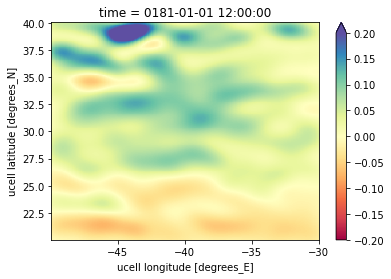

In [43]:
plt.figure()
filtered_data2.plot(**plt_args)

Plot of dxt over the map

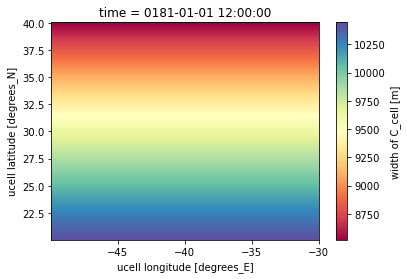

In [56]:
plt.figure()
grid_data['dxu'].plot(cmap='Spectral')#%%


Here we use a cartesian filter

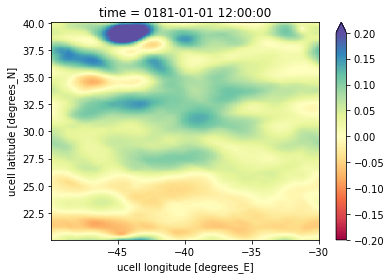

In [64]:
wet_mask = grid_data_save['wet'].interp(xt_ocean=data.xu_ocean,
                                        yt_ocean=data.yu_ocean)

cartesian_filter = filter.Filter(16, dx_min=1, n_steps=30,
                                 filter_shape=filter.FilterShape.GAUSSIAN,
                                 grid_vars={'wet_mask': wet_mask},
                                 grid_type=GridType.CARTESIAN_WITH_LAND)
filtered_data3 = cartesian_filter.apply(data, dims=['yu_ocean', 'xu_ocean'])

filtered_data3.plot(**plt_args)